In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib.colors import LogNorm
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset

In [22]:
class PolyModel(torch.nn.Module):
    def __init__(self, w0: float, in_features: int, out_features: int, 
                 w_init: Optional[Tensor] = None) -> None:
        super(PolyModel, self).__init__()
        
        self.w0 = w0
        
        # The model has two weights w1 and w2 for each output feature
        if w_init is not None:
            self.weight = torch.nn.Parameter(w_init)
        else:
            self.weight = torch.nn.Parameter(torch.randn((out_features, 2, in_features)))
                 
    def forward(self, input: Tensor):
        # Extracting w1 and w2 from the weight tensor
        w1, w2 = self.weight[:, 0, :], self.weight[:, 1, :]
        
        # Computing Q(w1, w2)
        poly = (w1 - self.w0) ** 2 * (w1 + self.w0) ** 3 * (w2 - 1)
        
        return input * poly
    
# Training model

def train_model(model, data_loader, num_epochs = 1000, lr=0.01):
    # Loss tracking
    running_loss = []
    running_weight = []

    # Loss and Optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training the Model
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in data_loader:
            # Forward pass
            y_pred = model(batch_x)
            loss = loss_function(y_pred, batch_y)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Tracking the cumulative loss for the current epoch
            epoch_loss += loss.item()

        # Calculate average loss for the current epoch
        avg_epoch_loss = epoch_loss / len(data_loader)
        running_loss.append(avg_epoch_loss)

        # Record the current model weight
        current_weight = model.weight.detach().clone()
        running_weight.append(current_weight)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {avg_epoch_loss}')
    return running_loss, running_weight

# Plot loss curve

def plot_loss_curve(running_loss):
    plt.plot(running_loss)
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Plot loss landscape

def plot_loss_landscape(model, x_data, y_data, 
                        weight_range, running_weight, linear=False):

    # Computing the loss for each weight value in the range
    loss_landscape = []
    loss_function = nn.MSELoss()

    for weight in weight_range:
        # Updating the model's weight and fixed bias
        if linear == True:
            model.linear.weight.data.fill_(weight)
        else:
            model.weight.data.fill_(weight) 
        
        # Forward pass with the updated weight
        y_pred = model(x_data)
        
        # Computing the loss
        loss = loss_function(y_pred, y_data)
        loss_landscape.append(loss.item())

    # Plotting the loss landscape
    
    plt.plot(weight_range, loss_landscape, label='Loss Landscape')

    # Plotting the trajectory of the weights during training
    plt.plot(running_weight, [loss_landscape[np.argmin(np.abs(weight_range - w))] for w in running_weight], 'ro-', label='Training Path', markersize=3)
    plt.title('Weight Dynamics on Loss Landscape')
    plt.yscale("log")
    plt.xlabel('Weight')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Train 2D polynomial model

Epoch 0, Loss: 1.3092598251998424
Epoch 10, Loss: 1.0645503094792366
Epoch 20, Loss: 1.0645503064990043
Epoch 30, Loss: 1.064550300836563
Epoch 40, Loss: 1.0645503187179566
Epoch 50, Loss: 1.0645503109693528
Epoch 60, Loss: 1.0645503255724906
Epoch 70, Loss: 1.0645503145456314
Epoch 80, Loss: 1.0645503121614457
Epoch 90, Loss: 1.0645503160357475


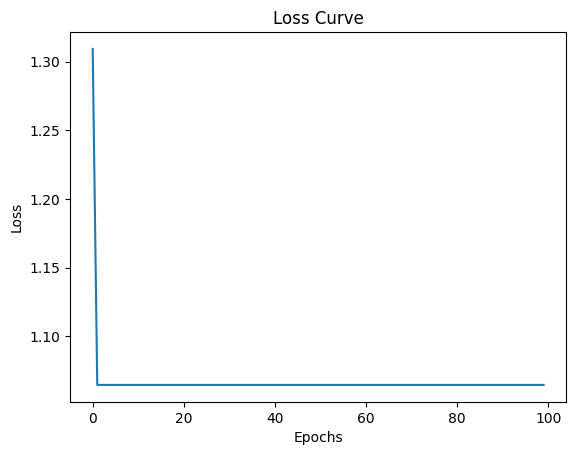

In [23]:
# Pramaters
lr = 0.01
num_epochs = 100
num_samples = 1000
batch_size = 10

# Generate data
#w_init = torch.Tensor([[w_init]])
torch.manual_seed(42) # for reproducibility
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training
model = PolyModel(w0=1.0,in_features=1, out_features=1)
loss_values, running_weight =  train_model(model, data_loader,num_epochs = num_epochs, lr=lr)
plot_loss_curve(loss_values)

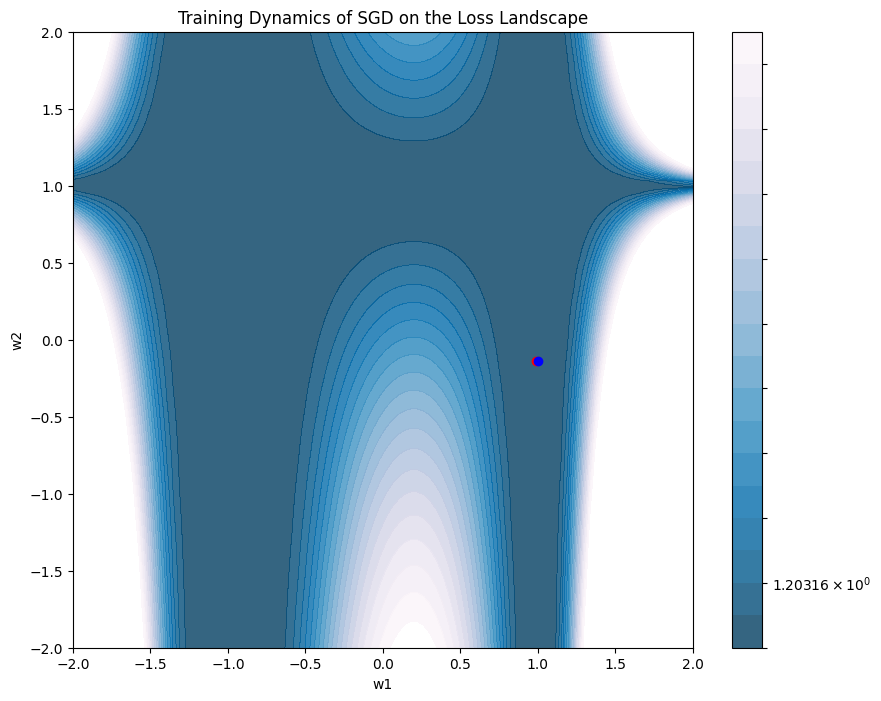

In [24]:
# Plot loss landscape
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))

# Weights trajectory
wx = [running_weight[i][:,0,:].item() for i in range(num_epochs)]
wy = [running_weight[i][:,1,:].item() for i in range(num_epochs)]

wmax = max(abs(num) for num in wx + wy) + 1

# Generate a grid of w1 and w2 values
w1_range = np.linspace(-wmax, wmax, 100)
w2_range = np.linspace(-wmax, wmax, 100)
W1, W2 = np.meshgrid(w1_range, w2_range)

model = PolyModel(w0=1.0, in_features=1, out_features=1)  # Initialize with the given w0 value
loss_function = torch.nn.MSELoss()

loss_landscape = np.zeros_like(W1)

for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w1_val = W1[i, j]
        w2_val = W2[i, j]
        
        # Set the weight values in the model correctly as a 3D tensor
        model.weight.data = torch.tensor([[[w1_val], [w2_val]]])
        
        # Compute the loss
        y_pred = model(x_data)
        loss = loss_function(y_pred, y_data)
        loss_landscape[i, j] = loss.item()


# Plot the contour map of the loss landscape
plt.figure(figsize=(10, 8))
contour = plt.contourf(W1, W2, loss_landscape, levels=np.logspace(np.log10(np.min(loss_landscape)),1,num=20), norm= LogNorm(), cmap='PuBu_r', alpha=0.8)
plt.colorbar(contour)
# Visualise weights trajectory
plt.plot(wx, wy, 'k--', linewidth=0.1, markersize=0.1)
plt.plot(wx[0], wy[0], 'ro')
plt.plot(wx[-1], wy[-1], 'bo')
plt.title("Training Dynamics of SGD on the Loss Landscape")
plt.xlabel("w1")
plt.ylabel("w2")
plt.show()

(60.0, 100.0)

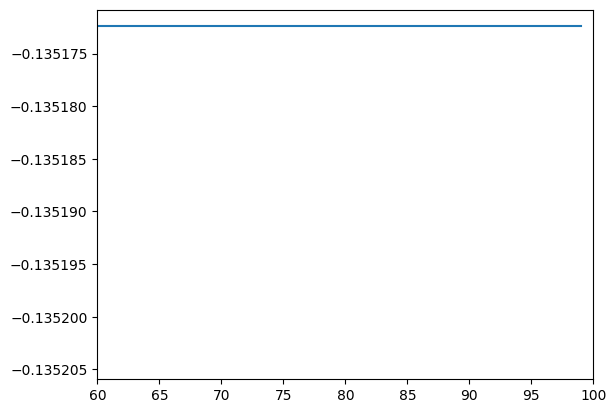

In [25]:
#plt.plot(wx)
plt.plot(wy)
plt.xlim((60,100))

In [26]:
print(np.min(loss_landscape))
print(np.max(loss_landscape))

0.9378347491084535
6241.74027105917
